## Cargar librerías

In [1]:
import matplotlib.pyplot as plt
import requests, re, os, glob
import pandas as pd
import numpy as np
import seaborn as sns

## Cambiar directorio

In [2]:
#os.chdir("/content/drive/MyDrive/PRONACES/python")
#Show directory
os.getcwd()

'c:\\Users\\pedro\\Documents\\programación\\python\\pronaces_analisis'

## Lista de archivos RETC

In [7]:
retcFiles = glob.glob("data/RETC_2004-2020/*.xlsx")
retcFiles[:5]

['data/RETC_2004-2020\\Inconsistencias_2004.xlsx',
 'data/RETC_2004-2020\\Inconsistencias_2006.xlsx',
 'data/RETC_2004-2020\\Inconsistencias_2007.xlsx',
 'data/RETC_2004-2020\\Inconsistencias_2008.xlsx',
 'data/RETC_2004-2020\\Inconsistencias_2009.xlsx']

In [68]:
unidades = {
    "ton":1,
    "ton/año":1,
    "kg":1/1000,
    "Kg":1/1000,
    "kg/año":1/1000,
    "g":1/(1000*1000),
    
}
columnasContaminantes = [
    'AIRE', 'AGUA', 'SUELO', 'REUTILIZACIÓN', 'RECICLADO',
    'COPROCESAMIENTO', 'TRATAMIENTO', 'DISPOSICIÓN\nFINAL',
    'ALCANTARILLADO', 'INCINERACIÓN', 'OTROS']

rename_columns = {
    "delegación\municipio":"municipio",
    'coordenada\nutm x':'coordenada utm x', 
    'coordenada\nutm y':'coordenada utm y',
    'coordenada \nutm x':"coordenada utm x", 
    'coordenada \nutm y':"coordenada utm y",
    'latitud \nnorte' :'latitud norte',  
    'longitud \noeste':'longitud oeste',
    'número exterior':'núm. ext',
    'número interior':'núm. int',
    'no. exterior':'núm. ext', 
    'no. interior':'núm. int',
    'c.p.':"código postal",
    'clave\nambiental':'clave ambiental',
    'principal actividad productiva':'actividad principal',
    "descripción":"sustancia",
    "no. cas":"cas",
    "entidad federativa":"estado",
    "sustancias":"sustancia",
    "disposición\nfinal":"disposición final",
    "otros":"otro"
    }

col_emisiones = ['aire', 'agua', 'suelo', 'reuso']
col_transferencia = ['reciclado', 'coprocesamiento',
  'tratamiento', 'disposición final', 'alcantarillado', 'otro',
  'incineración', 'reutilización', 'establecimiento']

col_emisiones + col_transferencia

['aire',
 'agua',
 'suelo',
 'reuso',
 'reciclado',
 'coprocesamiento',
 'tratamiento',
 'disposición final',
 'alcantarillado',
 'otro',
 'incineración',
 'reutilización',
 'establecimiento']

## Read RETC file

In [99]:
retcEmisiones = pd.DataFrame()
for file in retcFiles:
  year = file[-9:-5]
  # read excel file and use second sheet
  df = pd.read_excel(file, sheet_name=1)
  try:
    index = df[df.iloc[:,0] == 'NRA'].index[0]
  
  except IndexError:
    df['year'] = year
    df.columns = df.columns.str.lower()
    df.rename(columns=rename_columns, inplace=True)
    df["unidad"].replace(unidades, inplace=True)
    df = df[df['estado'] == 'COLIMA']
    print(df.shape, year, file)
    retcEmisiones = pd.concat([retcEmisiones, df], ignore_index=True)
    continue

  header = df.iloc[df[df.iloc[:,0] == 'NRA'].index[0]]
  df.columns = header
  
  df = df.iloc[index+1:]
  # remove rows over df[df.iloc[:,0] == 'NRA'].index[0]
  #df = df[:df[df.iloc[:,0] == 'NRA'].index[0]]
  df['year'] = year
  df.columns = df.columns.str.lower()
  df.rename(columns=rename_columns, inplace=True)
  df["unidad"].replace(unidades, inplace=True)
  df = df[df['estado'] == 'COLIMA']
  print(df.shape, year, file)
  retcEmisiones = pd.concat([retcEmisiones, df], ignore_index=True)
  
  
for col in col_emisiones + col_transferencia:
  try:
    retcEmisiones[col] = retcEmisiones[col] * retcEmisiones["unidad"]  
  except:
    continue
#retcEmisiones = retcEmisiones[retcEmisiones['estado'] == 'COLIMA']
retcEmisiones

(0, 19) 2004 data/RETC_2004-2020\Inconsistencias_2004.xlsx
(0, 20) 2006 data/RETC_2004-2020\Inconsistencias_2006.xlsx
(0, 20) 2007 data/RETC_2004-2020\Inconsistencias_2007.xlsx
(0, 20) 2008 data/RETC_2004-2020\Inconsistencias_2008.xlsx
(0, 20) 2009 data/RETC_2004-2020\Inconsistencias_2009.xlsx
(0, 20) 2010 data/RETC_2004-2020\Inconsistencias_2010.xlsx
(0, 20) 2011 data/RETC_2004-2020\Inconsistencias_2011.xlsx
(0, 21) 2012 data/RETC_2004-2020\Inconsistencias_2012.xlsx
(3, 20) 2013 data/RETC_2004-2020\Inconsistencias_2013.xlsx
(21, 20) 2014 data/RETC_2004-2020\Inconsistencias_2014.xlsx
(7, 20) 2015 data/RETC_2004-2020\Inconsistencias_2015.xlsx
(1, 20) 2016 data/RETC_2004-2020\Inconsistencias_2016.xlsx
(16, 20) 2017 data/RETC_2004-2020\Inconsistencias_2017.xlsx
(22, 20) 2018 data/RETC_2004-2020\Inconsistencias_2018.xlsx
(30, 20) 2019 data/RETC_2004-2020\Inconsistencias_2019.xlsx
(20, 20) 2020 data/RETC_2004-2020\Inconsistencias_2020.xlsx
(23, 19) 2004 data/RETC_2004-2020\retc 2004.xlsx
(5

,nra,nombre,estado,sector,sustancia,cas,unidad,aire,agua,suelo,...,tratamiento,disposición final,alcantarillado,otro,incineración,year,municipio,reutilización,establecimiento,grupo sustancia
0,CFEAD0600711,"COMISIÓN FEDERAL DE ELECTRICIDAD, CENTRAL TERM...",COLIMA,Generación de energia electrica,Bióxido de nitrógeno,10102-44-0,0.001,22288040,0,0,...,0,0,0,0,0,2013,Manzanillo,0,NaN,NaN
1,PREM90600723,PEMEX REFINACION TERMINAL DE ALMACENAMIENTO MA...,COLIMA,Petroleo y petroquimica,Acroleina,107-02-8,0.001,195282,0,0,...,0,0,0,0,0,2013,Manzanillo,0,NaN,NaN
2,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Cromo (compuestos),S/C3,0.001,1727.39,0,0,...,0,0,0.0436,0,0,2013,Manzanillo,0,NaN,NaN
3,CFEAD0600711,"COMISIÓN FEDERAL DE ELECTRICIDAD,COMPLEJO TERM...",COLIMA,Generación de energia electrica,Arsénico (compuestos),As,0.001,0.0,2729.2575,0.0,...,0.0,0.0,0.0,0.0,0.0,2014,Manzanillo,0.0,NaN,NaN
4,CFEAD0600711,"COMISIÓN FEDERAL DE ELECTRICIDAD,COMPLEJO TERM...",COLIMA,Generación de energia electrica,Cadmio (compuestos),Cd,0.001,0.0,27292.5752,0.0,...,0.0,0.0,0.0,0.0,0.0,2014,Manzanillo,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,TSHBB0600711,"TERMINAL DE SERVICIOS HAZESA S.A. DE C.V.,TERM...",COLIMA,Petroleo y petroquimica,Plomo (compuestos),Pb,0.001,0.0,0.0003,0.0,...,0.0,0.0,12.4611,0.0,0.0,2020,Manzanillo,0.0,NaN,NaN
1250,UME750600911,"USG MEXICO, S.A DE C.V,USG MEXICO, S.A. DE C.V...",COLIMA,Cemento y Cal,Bióxido de carbono,124-38-9,0.001,13137940.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2020,Tecoman,0.0,NaN,NaN
1251,UME750600911,"USG MEXICO, S.A DE C.V,USG MEXICO, S.A. DE C.V...",COLIMA,Cemento y Cal,"Níquel (polvos respirables, humos o vapores)",7440-02-0,0.001,0.0,0.0,0.0,...,0.0,3.3488,0.0,0.0,0.0,2020,Tecoman,0.0,NaN,NaN
1252,YCS750600611,"YESERA COLIMA SA DE CV,YESERA COLIMA",COLIMA,Cemento y Cal,Bióxido de carbono,124-38-9,0.001,407091.8963,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2020,Ixtlahuacan,0.0,NaN,NaN


In [100]:
retcEmisiones['year'].unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012'], dtype=object)

In [103]:
#retcEmisionesNoNaN = retcEmisiones[retcEmisiones["emision"].notna()].copy()
# Keep only rows with "emision" column upper than 0
municipalitiesToKeep = ['Tecoman', 'Manzanillo', 'Colima', 'Cuauhtemoc', 'Minatitlan']
retcEmisionesNoNaN = retcEmisiones[retcEmisiones["municipio"].isin(municipalitiesToKeep)].copy()
#retcEmisiones = retcEmisiones[retcEmisiones["emision"] > 1].copy()

In [104]:
retcEmisiones.year.unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012'],
      dtype=object)

In [105]:
# Replace content of "nombre" column if contains "CEMENTOS APASCO S.A. DE C.V.	"
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("APASCO"), "nombre"] = "CEMENTOS APASCO S.A. DE C.V."
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("COMISIÓN FEDERAL DE ELECTRICIDAD"), "nombre"] = "CENTRAL TERMOELECTRICA MANZANILLO"
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("CONSORCIO MINERO BENITO"), "nombre"] = 'PEÑA COLORADA'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nombre"].str.contains("Danisco Mexicana S.A. de C.V.	"), "nombre"] = 'DANISCO MEXICANA, S.A. DE C.V.'



ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [ ]:
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("DMEBF0600911"), "nombre"] = 'DANISCO MEXICANA, S.A. DE C.V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ENC110600511"), "nombre"] = 'LAS ENCINAS S.A. DE C.V. PLANTA PELETIZADORA'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("UME750600911"), "nombre"] = 'USG MEXICO S.A. DE C.V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("PTA640600911"), "nombre"] = 'PRODUCTOS TANIART S.A DE C.V'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("MAR1Z0600711"), "nombre"] = 'MARINDUSTRIAS S. A. DE C. V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ENC110600911"), "nombre"] = 'LAS ENCINAS S.A. DE C.V. PLANTA PELETIZADORA'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ECOLY0600911"), "nombre"] = 'Ecoltec S.A. de C.V.'.upper()

retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("EOMMI0600711"), "nombre"] = 'ENERGÍA OCCIDENTE DE MÉXICO S. DE R. L. DE C. V.'
retcEmisionesNoNaN.loc[retcEmisionesNoNaN["nra"].str.contains("ECOUB0600211"), "nombre"] = 'ECOSISTEMA DE COLIMA S.A. DE C.V.,'

In [ ]:
retcEmisionesNoNaN["localidad"].replace({
    "COLIMA": "Colima",
    "MANZANILLO": "Manzanillo",
    'MANZANILLIO': "Manzanillo",
    'CUAUHTEMOC': "Cuauhtémoc",
    'Tecoman' : "Tecomán",
}, inplace=True)

# Capitalize first letter of each word in "localidad" column
retcEmisionesNoNaN["localidad"] = retcEmisionesNoNaN["localidad"].str.title()
retcEmisionesNoNaN["nombre"] = retcEmisionesNoNaN["nombre"].str.upper()

In [106]:
retcEmisionesNoNaN[retcEmisionesNoNaN['localidad'].isna()]#.drop_duplicates(subset=["nra", "nombre"])

KeyError: 'localidad'

In [ ]:
dfFinal = pd.DataFrame()
for index, df in retcEmisionesNoNaN.groupby("nra"):
  # fill NaN values in "nombre" using the first value
  df['nombre'].fillna(method='ffill', inplace=True)
  df['localidad'].fillna(method='ffill', inplace=True)
  
  dfFinal = pd.concat([dfFinal, df], ignore_index=True)

dfFinal

,nra,nombre,estado,sector,sustancia,cas,contaminante,emision,year,latitud norte,longitud oeste,municipio,localidad
0,AMT640600911,AMTEX S.A DE C.V.,COLIMA,Quimica,Bióxido de carbono,124-38-9,aire,2086.71,2005,"19°14'15.03""","103°43'39.09""",Colima,Tecoman
1,AMT640600911,AMTEX S.A DE C.V.,COLIMA,Quimica,Bióxido de carbono,124-38-9,aire,1.53052,2006,"19°14'15.03""","103°43'39.09""",Colima,Tecoman
2,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Bióxido de carbono,124-38-9,aire,1035641.88,2004,"18°58'43""","103°52'18""",Tecoman,Caleras
3,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,6.152,2004,"18°58'43""","103°52'18""",Tecoman,Caleras
4,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,7.604,2005,"18°58'43""","103°52'18""",Tecoman,Caleras
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Bióxido de carbono,124-38-9,aire,1.1579,2010,"19°0'52""","104°16'50""",Manzanillo,Campos
287,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Bióxido de carbono,124-38-9,aire,5.2836,2011,"19°0'34""","104°16'22""",Manzanillo,Campos
288,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Bióxido de carbono,124-38-9,aire,2.051,2012,"19°0'34""","104°16'22""",Manzanillo,Campos
289,ZEPQY0600711,ZETA GAS DEL PACIFICO S.A. DE C.V.,COLIMA,Petroleo y petroquimica,Níquel (compuestos),S/C5,aire,2.35063,2013,"19°0'34""","104°16'22""",Manzanillo,Campos


In [ ]:
dfFinal.year.unique()

array([2004, 2005, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2015, 2016,
       2017, 2020, 2007, 2018, 2019, 2014], dtype=int64)

In [ ]:
# show how many unique values are in "sustancia" column
dfFinal["sustancia"].unique()

array(['Bióxido de carbono', 'Benceno', 'Oxido nitroso',
       'Bióxido de nitrógeno', 'Plomo (compuestos)',
       'Arsénico (compuestos)', 'Cadmio (compuestos)',
       'Cromo (compuestos)', 'Mercurio (compuestos)',
       'Níquel (compuestos)', 'Cianuro inorgánico/orgánico', 'Metano',
       'Plomo (polvos respirables, humos o vapores)',
       'Clorodifluorometano (HCFC-22)', 'Asbesto'], dtype=object)

In [ ]:
# save to excel file
#dfFinal.to_excel("data/emisiones.xlsx", index=False)

In [ ]:
dfFinal["sustancia"].unique()

array(['Bióxido de carbono', 'Benceno', 'Oxido nitroso',
       'Bióxido de nitrógeno', 'Plomo (compuestos)',
       'Arsénico (compuestos)', 'Cadmio (compuestos)',
       'Cromo (compuestos)', 'Mercurio (compuestos)',
       'Níquel (compuestos)', 'Cianuro inorgánico/orgánico', 'Metano',
       'Plomo (polvos respirables, humos o vapores)',
       'Clorodifluorometano (HCFC-22)', 'Asbesto'], dtype=object)

In [ ]:
quimicos_to_remove = [
  'Bióxido de carbono','Oxido nitroso','Bióxido de nitrógeno','Metano',
]

In [ ]:
dfFinal = dfFinal[~dfFinal["sustancia"].isin(quimicos_to_remove)].copy()

In [ ]:


# replace "municipio" values
rename_municipios = {
  "Tecoman": "Tecomán",
  "Minatitlan": "Minatitlán",
  "Cuauhtemoc": "Cuauhtémoc",
}

dfFinal["municipio"].replace(rename_municipios, inplace=True)
dfFinal["municipio"].unique()

array(['Tecomán', 'Manzanillo', 'Minatitlán', 'Colima'], dtype=object)

# Panorama general de los datos

In [ ]:
dfFinal.head()

,nra,nombre,estado,sector,sustancia,cas,contaminante,emision,year,latitud norte,longitud oeste,municipio,localidad
3,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,6.152,2004,"18°58'43""","103°52'18""",Tecomán,Caleras
4,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,7.604,2005,"18°58'43""","103°52'18""",Tecomán,Caleras
6,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,8.5287,2006,"18°58'43""","103°52'18""",Tecomán,Caleras
9,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,5.2165,2008,"18°58'43""","103°52'18""",Tecomán,Caleras
11,CAP730600911,CEMENTOS APASCO S.A. DE C.V.,COLIMA,Cemento y Cal,Benceno,71-43-2,aire,6.2648,2009,"18°58'43""","103°52'18""",Tecomán,Caleras


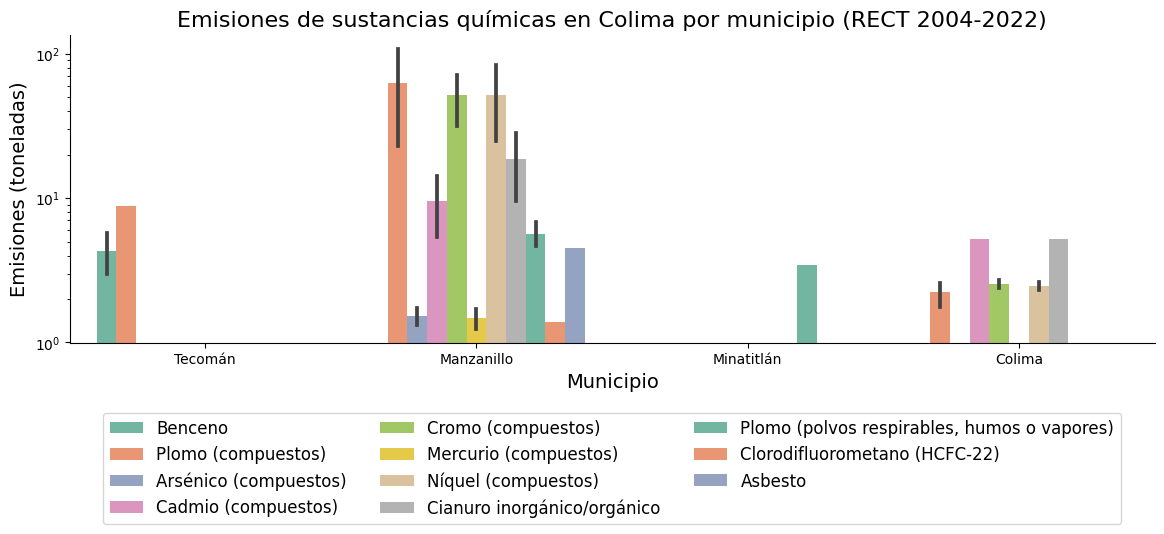

In [ ]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por municipio (RECT 2004-2022)", fontsize=16)
# put values in log scale
# set scale to log
sns.barplot(x="municipio", y="emision", data=dfFinal, hue="sustancia", ax=ax, log=True, palette="Set2")

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Municipio", fontsize=14)

# add beautiful legend

ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), fontsize=12)
sns.despine()
plt.show()

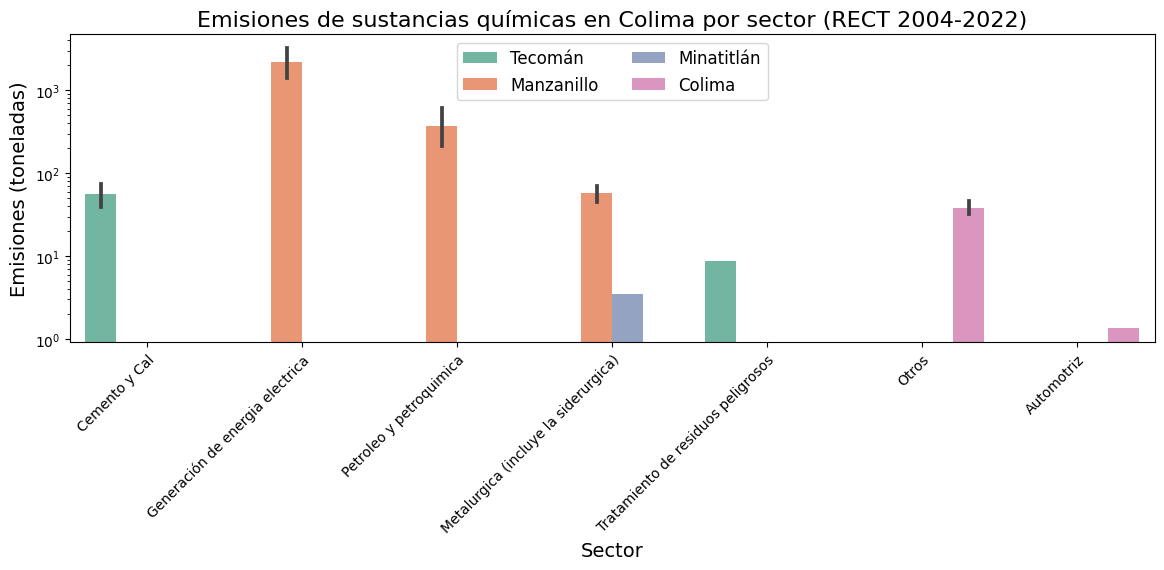

In [ ]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sector (RECT 2004-2022)", fontsize=16)

# generate a barplot with log scale and summing the values of "emision" column
sns.barplot(x="sector", y="emision", data=dfFinal, hue="municipio", ax=ax, log=True, palette="Set2", estimator=sum)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Sector", fontsize=14)

# add beautiful legend

# rotate xticks 90 degrees
plt.xticks(rotation=45)

ax.legend(loc='upper center', ncol=2,  fontsize=12)

# wrap xticks labels
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

plt.show()

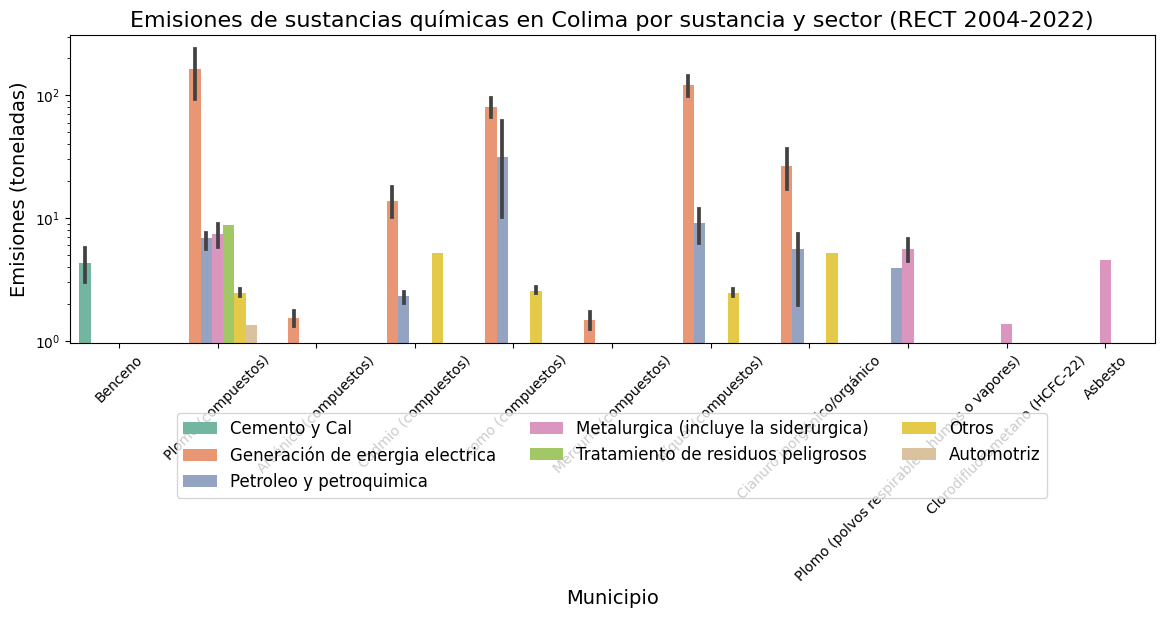

In [ ]:

fig, ax = plt.subplots(figsize=(14, 4))

ax.set_title("Emisiones de sustancias químicas en Colima por sustancia y sector (RECT 2004-2022)", fontsize=16)

sns.barplot(x="sustancia", y="emision", data=dfFinal, hue="sector", ax=ax, log=True, palette="Set2")

# rotate xticks 90 degrees
plt.xticks(rotation=45)
ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), fontsize=12)

ax.set_ylabel("Emisiones (toneladas)", fontsize=14)
ax.set_xlabel("Municipio", fontsize=14)



plt.show()
